# Automated Mapping of Qat Farms in Yemen with Sentinel-2 MS Imagery

## Overview
Qat is an evergreen shrub native to the Arabian Peninsula and the Horn of Africa. Many people across East Africa (Ethiopia, Eriterea, Kenya, Somalland and Djepute) and Yemen have become addicted to pleasurable and stimulating effects of chewing and smoking qat leaves - it is classified by WHO as a 'drug of abuse'. In Yemen, its consumption has spread from the elite to become a focal point of social and business life with increasing numbers of women and teenagers also indulging in the habit. Sales of qat in Yemen are estimated to run to $800 million (5.8 million euros) a year, a huge sum in a country ranked by the United Nations as 160th in the world for human development, the lowest in Asia bar war-torn Afghanistan.

Only 10,000 hectares (25,000 acres) were given over to cultivation of the crop in the 1970s. By 2012, that figure had risen to 167,602 hectares (414,153 acres), accounting for 12 percent of Yemen's arable land. According to the Yemeni agriculture ministry, Qat can earn $12,500 a hectare, three times the revenue of any other crop. It takes five years to get a harvest from a fruit tree but just a few months for a qat plant, and it can be harvested as many as four times a year. 

![A country chewing itself to death](./assets/qat_man_in_yemen.jpg)

Together with social issues caused by Qat addiction (crime, medical, unemployment, etc.), qat crops require substantial irrigation to ensure that its tender leaves and shoots are soft and moist for chewing. One day's supply of qat for a single user requires an estimated 500 litres (130 gallons) of water to produce. Unregulated drilling of additional wells and excessive pumping of irrigation water has significantly lowered the level of the water table across many areas.

In a country that enjoys much higher rainfall that its mainly desert neighbour Saudi Arabia, mains water is heavily rationed. In Sanaa, a city of some three million people, less than half of domestic households have only occasional access to mains water (1-2 times a week). Approximately a third of the three billion cubic metres (106 billion cubic feet) of water that Yemen consumes each year comes from renewable sources - the rest comes from aquifers that have taken millions of years to form and cannot be replaced. Yemen as a country, is almost literally [chewing itself to death.](https://www.theguardian.com/environment/2010/feb/26/yemen-qat-water-drought)

Analysis of historical and contemporary satellite imagery offers government bodies and humanitarian agencies a potentially valuable insight into spatial distribution and spread of qat industry across Yemen. Accurate maps of individual qat farms facilitate rapid identification of illegal boreholes and help support strategic re-development of local economy.

This GitHub project outlines a methodology for training a U-Net based Convolutional Neural Network to discriminate and segment unique spectral characteristics of qat crops in Sentinel-2 multispectral imagery. With reference to https://github.com/chris010970/qat/src/train.py, this project leveraged functional capabilities of the [keras-unet-collection](https://github.com/yingkaisha/keras-unet-collection) library - community tested, highly configurable TensorFlow / Keras implementations of the original U-Net architecture plus several variants including Attention U-Net, U-Net plus plus, and R2-U-Net.

## Ground Truth

Ground truth denoting locations of large scale qat farming was obtained from [OpenStreetMap](https://www.openstreetmap.org/) and [ACAPS](https://en.wikipedia.org/wiki/ACAPS) - a non-profit, non-governmental project providing daily monitoring across 150 countries to support humanitarian aid workers. Georeferenced polygons delineating extent of nearby qat crops were manually created using OpenStreetMap annotation tools in conjunction with very high resolution Maxar Vivid [basemap](https://www.maxar.com/products/imagery-basemaps).

In [1]:
from keras_unet_collection import models

In [2]:
import os
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

# load train and test polygons
dfs = {}
for key in [ 'train', 'test' ]:
    df = gpd.read_file( os.path.join( 'assets', f'{key}.shp' ) )
    dfs[ key ] = df.to_crs(epsg=3857)

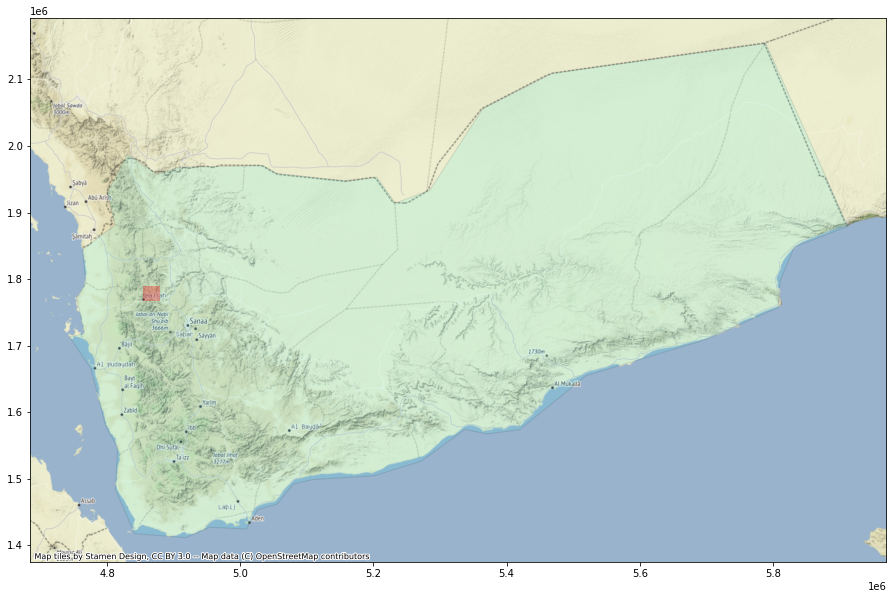

In [3]:
# plot yemen border
world = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres") )
world = world.to_crs(epsg=3857)
ax = world[world.name == 'Yemen'].plot( figsize=(20,10), color='cyan', edgecolor='black', alpha=0.1 )

# get extended aoi
minx, miny, maxx, maxy = dfs[ 'train' ].total_bounds
minx -= 10000; miny -= 10000; maxx += 10000; maxy += 10000;

# create polygon aoi
geom = Polygon(zip( [ minx, maxx, maxx, minx ], [ miny, miny, maxy, maxy]))
aoi = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[geom])  

# plot aoi with basemap
aoi.plot( ax=ax, color='red', alpha=0.3  )
ctx.add_basemap(ax,zoom=8)

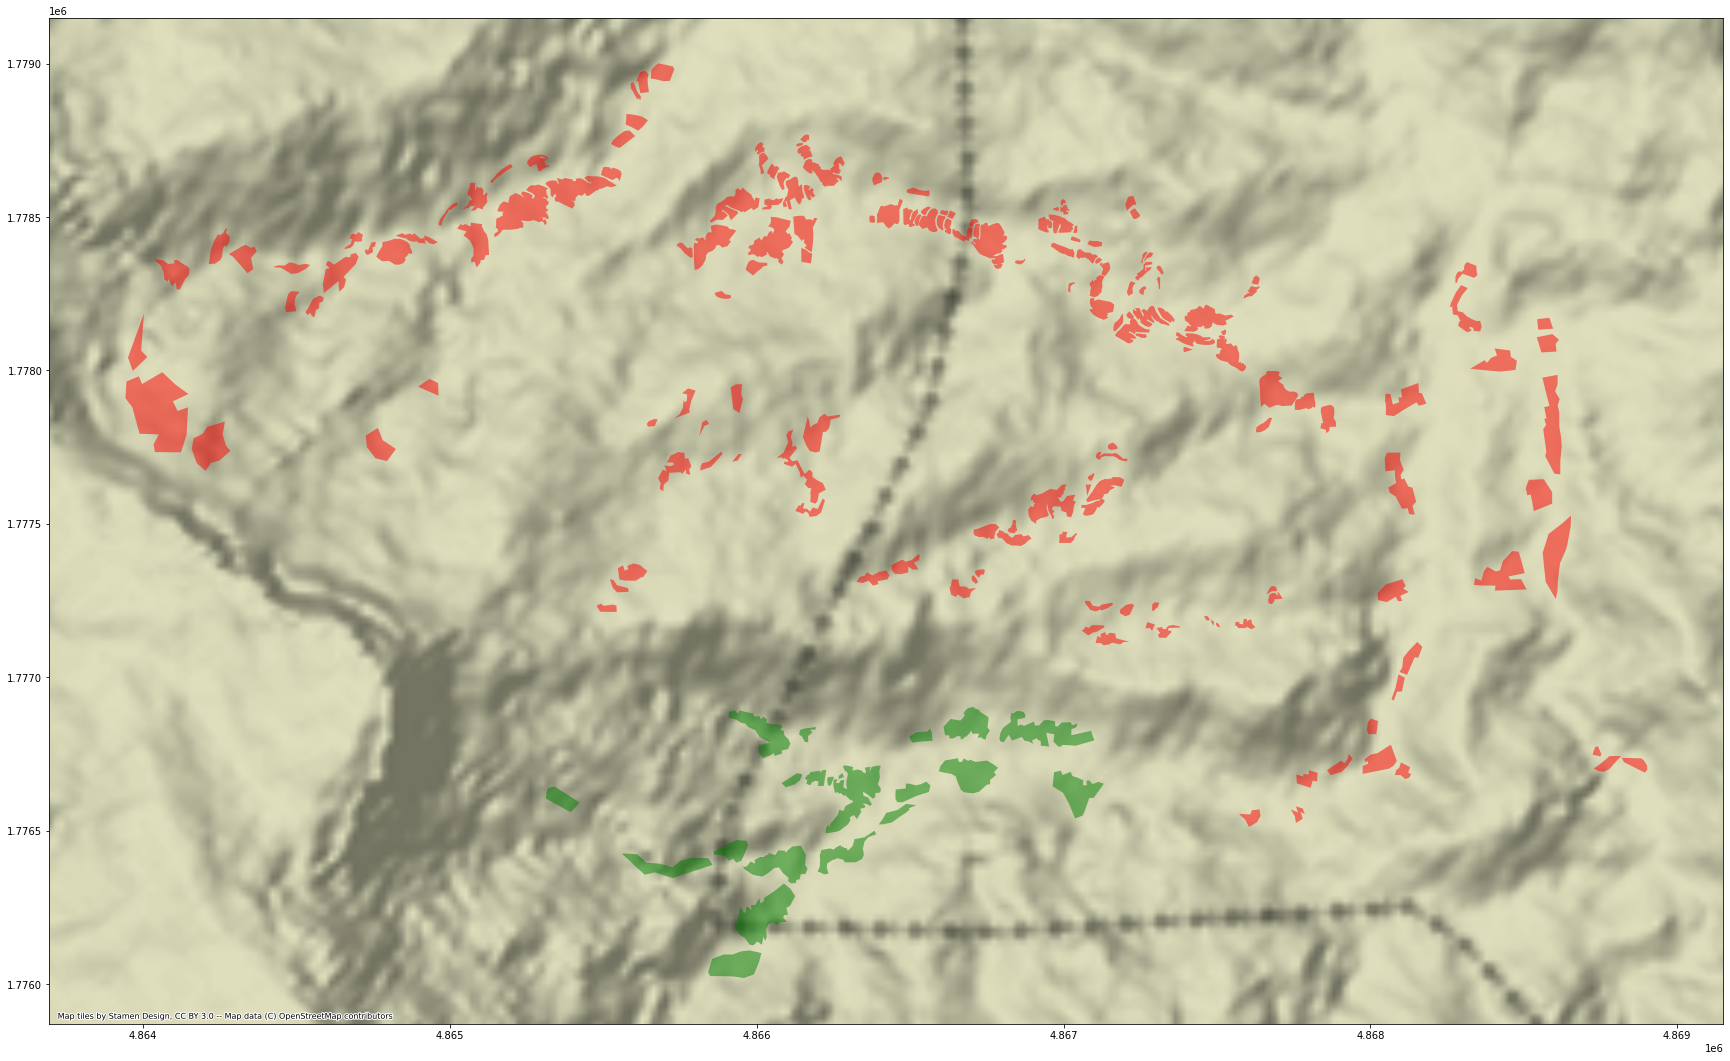

In [4]:
# plot train and val / test polygons
ax = dfs[ 'train' ].plot( figsize=(30,20), alpha=0.5, color='r' )
dfs[ 'test' ].plot(ax=ax, alpha=0.5, color='g')
ctx.add_basemap(ax,zoom=13)

## Data Curation

Sentinel-2 multispectral imagery collocated with annotated polygons visualised above was downloaded utilising the functionality of Sentinel-Hub Process API client: https://github.com/chris010970/sentinelhub/tree/main/src. Client code was  initialised using the YAML configuration file shown below - responses from Sentinel-Hub server included all 10m and 20m channel data (upsampled to 10m) in GeoTIFF format. Over 7500 images acquired between January 2020 and September 2020 with less than 5% cloud contamination were downloaded for this study.
```yaml
request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12" ],
                            units: ["DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN" ] 
                        }],
                        output: {
                            bands: 9, sampleType: SampleType.UINT16
                        }
                    };
                }
                function evaluatePixel(sample) {
                    //return [ sample.B04, sample.B03, sample.B02];
                    return [ sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B11, sample.B12 ]                    
                }
    inputs:
        - collection: SENTINEL2_L2A
          options:
            processing:
                upsampling: BICUBIC 
                downsampling: BILINEAR
          catalog:    
            query: |
                {
                    "eo:cloud_cover": {
                        "lt": 5
                    }
                }
            fields: |
                {
                    "include": [
                        "id",
                        "properties.datetime",
                        "properties.eo:cloud_cover"
                    ],
                    "exclude": []
                }   
responses:
    default: TIFF
aoi:
    pathname: D:\SAC\Qat_locations\qat_farms.shp
    name: name
    distance: 500
```

To reduce computational overheads, dimensions of the U-Net model input layer were configured as (64x64x9) - multispectral Sentinel-2 GeoTIFF imagery was therefore cropped to 64x64 pixel size. Qat farm annotation collocated with real-world extent of each training image was burnt into a companion 64x64 pixel binary label mask using the functionality of the image-labeller project: https://github.com/chris010970/image-labeller. 

In [5]:
# get notebooks parent directory
cwd = os.getcwd()
root_path = cwd[ : cwd.find( 'notebooks' )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\qat\\'

In [6]:
# add parent path
import sys; 
sys.path.append( os.path.join( root_path, 'src' ) )
os.path.join( root_path, 'src' )

'C:\\Users\\crwil\\Documents\\GitHub\\qat\\src'

In [7]:
# data path
data_path = 'C:\\Users\\crwil\\Documents\\data\\qat'

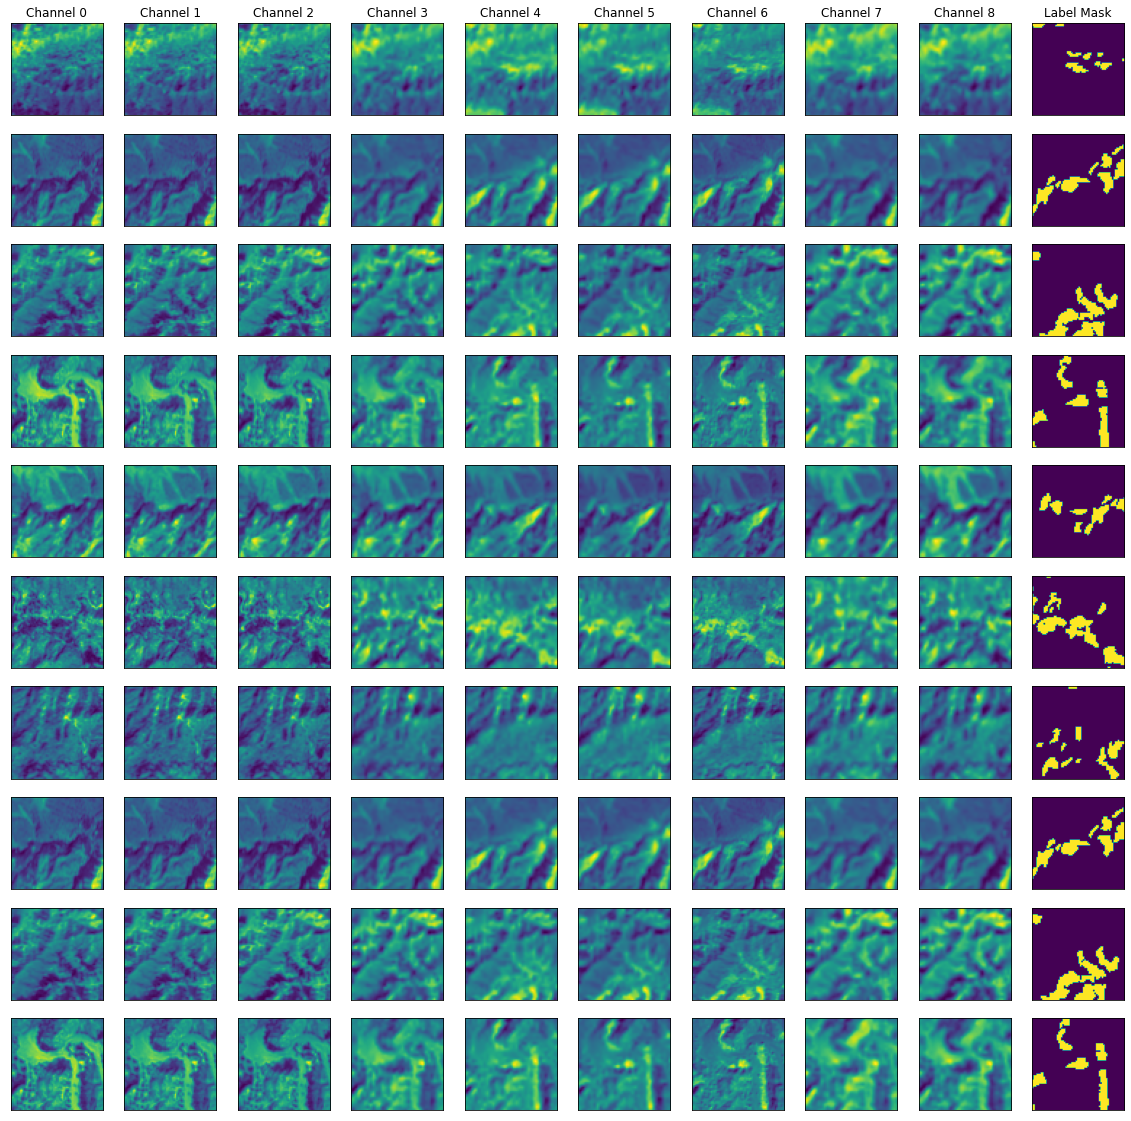

In [8]:
import glob
import random
from farm import Farm

# compile prefixes
farm = Farm( 64, 64, 9 )
train_path = os.path.join( data_path, 'train' )

# display s2 channels + label mask
nrows = 10
fig, axes = plt.subplots(nrows=nrows, ncols=10, figsize=(20, 20))

row = 0
while True:

    # pick random qat polygon index
    idx = random.randint(0, 190)    
    samples = glob.glob( os.path.join( train_path, f'images\\*aoi-{idx}_*.tif' ), recursive=True )
    if len( samples ) > 1:

        # load multichannel image + label mask
        prefix = os.path.splitext( os.path.basename( samples[ 0 ] ) )[ 0 ]
        
        image = farm.loadImages( train_path, prefix )                
        label = farm.loadLabels( train_path, prefix )
        
        # plot imagery + mask
        for channel in range( 9 ):
            axes[ row ][ channel ].imshow( image [ ::, ::, channel ] )            
            axes[ row ][ channel ].get_xaxis().set_ticks([])
            axes[ row ][ channel ].get_yaxis().set_ticks([])
            
            if row == 0:
                axes[ 0 ][ channel ].set_title( f'Channel {channel}' )
                            
        # remove axes ticks
        axes[ row ][ 9 ].imshow( label [ ::, ::, 0 ] )
        axes[ row ][ 9 ].get_xaxis().set_ticks([])
        axes[ row ][ 9 ].get_yaxis().set_ticks([])

        if row == 0:
            axes[ 0 ][ 9 ].set_title( 'Label Mask' )
        
        # quit if plot filled
        row += 1
        if row == nrows:
            break            

<BarContainer object of 3 artists>

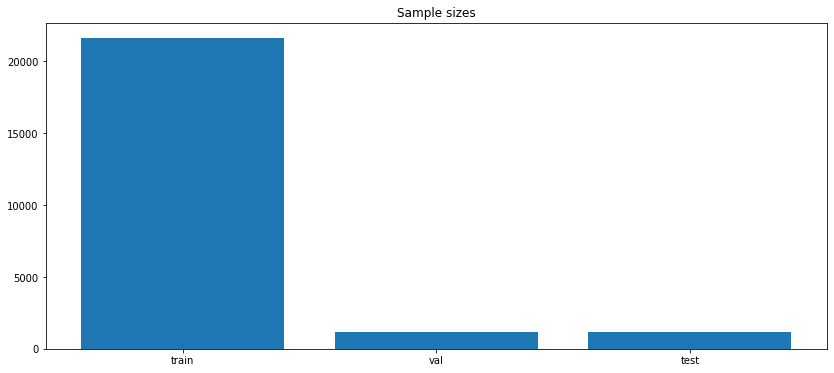

In [9]:
import matplotlib.pyplot as plt

# plot subset sample sizes for wet and dry classes
fig, ax = plt.subplots(figsize=(14, 6))

# get file list length - sample size
count = []
for idx, subset in enumerate( [ 'train', 'val', 'test' ] ):
    count.append( len( os.listdir ( os.path.join( data_path, os.path.join( subset, 'images' ) ) ) ) )
    
# draw counts as subplot
ax.set_title( 'Sample sizes' )
ax.bar( [ 'train', 'val', 'test' ], count )

Channel-specific statistics (mean and standard deviation) were computed across the entire training dataset. To compensate for scaling and distribution differences, pixel values of randomly selected mini-batches of training images were converted to standard z scores - mean of zero and standard deivation of 1.0 - before computing loss function.

In [10]:
import pandas as pd

# get image stats - required for image normalisation
image_stats = pd.read_csv( os.path.join( root_path, os.path.join( 'data', 'image_stats.csv' ) ) )
image_stats

channel         mean       stdev
0      0.0  1048.423795  350.223927
1      1.0  1404.042148  364.189559
2      2.0  1609.673696  435.940589
3      3.0  1892.795345  391.420349
4      4.0  2255.318013  408.500690
5      5.0  2418.785932  461.939499
6      6.0  2373.120764  480.727638
7      7.0  2840.107394  489.168789
8      8.0  2269.091650  483.501194

## Model Architecture

Using keras-unet-collection Python library, a standard U-Net Convolutional Neural Network model architecture was trained to transform 64x64x9 S2 multispectral imagery into pixel-wise 64x64x2 binary classification image (background, qat farm). Number of encoder and decoder convolutional blocks (3) was reduced to compensate for reduced image size - bilinear interpolation was utilised to upscale outputs in the decoder section of the model.

In [11]:
# print model summary
model = models.unet_2d((None, None, 9), [64, 128, 256], n_labels=2,
                        stack_num_down=2, stack_num_up=2,
                        output_activation='Softmax', 
                        batch_norm=True, 
                        pool='max', 
                        unpool='bilinear', 
                        name='unet')

model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, None, None, 6 5184        input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, None, None, 6 256         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, None, None, 6 0           unet_down0_0_bn[0][0]            
_________________________________________________________________________________________

In [12]:
# load trained weights
cwd = os.getcwd()
root_path = cwd[ : cwd.find( 'notebooks' )]
model.load_weights( os.path.join( root_path, os.path.join( 'data', 'weights.h5' ) ) )

## Training Results

Due to GPU memory constraints, a mini-batch size of 8 was selected. Training was executed using Adam optimiser with a learning rate of 1e-6 configured with Dice coefficient loss function. Validation loss converged to ~0.1 after ~100 epochs suggesting that the model had converged to a sufficiently generalised solution during training.

<AxesSubplot:title={'center':'Train vs Validation Loss (Dice Coefficient)'}>

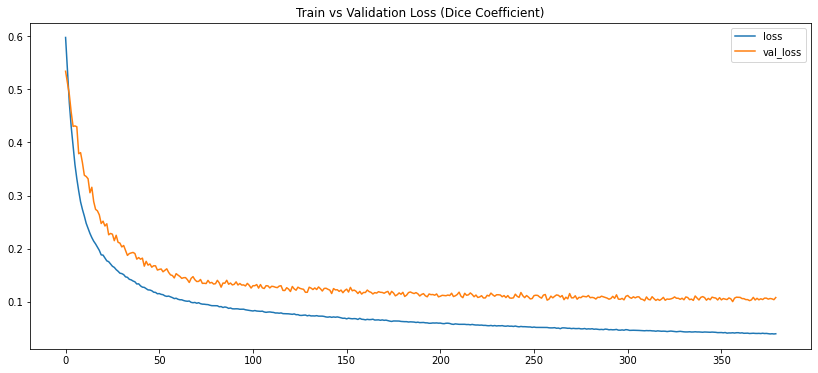

In [13]:
import pandas as pd

# plot diagnostics of model downloaded from GCS
df=pd.read_csv( os.path.join( os.getcwd(), 'assets\\log.csv') )
fig, ax = plt.subplots(figsize=(14, 6))
df.plot.line( ax=ax, title='Train vs Validation Loss (Dice Coefficient)', y=['loss', 'val_loss' ] )

In [14]:
def normaliseBand( band ):

    # compute 16-bit to 8bit min / max scaling factors
    r = np.percentile( band, [ 2, 98 ] )            
    band = (( band - r[0]) / (r[1] - r[0] ) ) * 255.0

    # clip to 8bit
    return np.clip( band, a_min=0.0,a_max=255.0 )

In [15]:
import generator 
import numpy as np

def getPredictions( images ):
    
    # apply normalisation / standardisation
    batch = []
    for image in images:
        batch.append( generator.standardiseImage( image, image_stats ) )

    # compute prediction
    return model.predict( np.asarray( batch ), batch_size=4 )

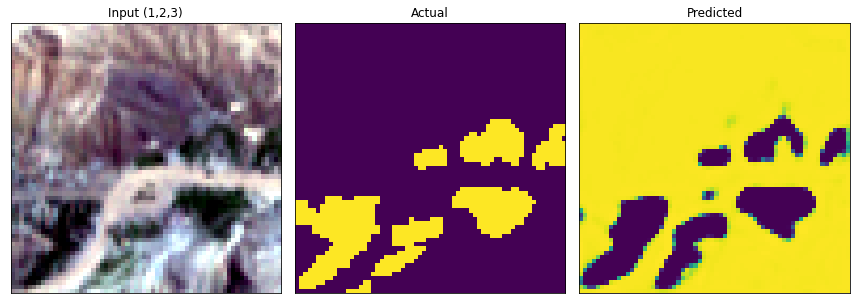

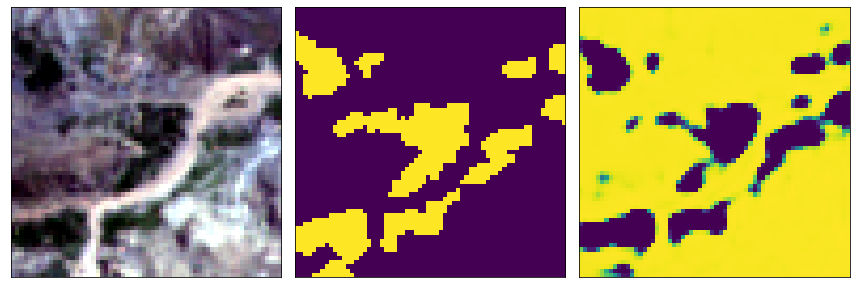

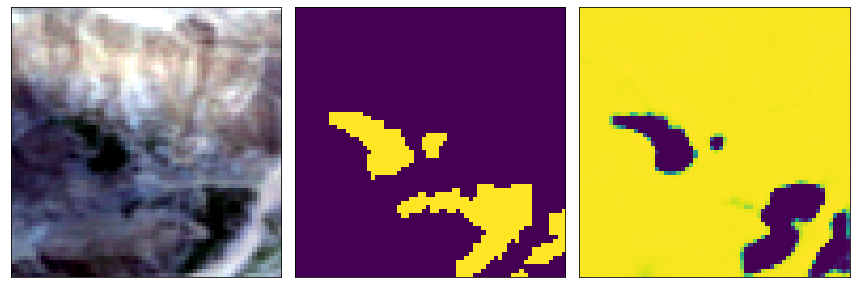

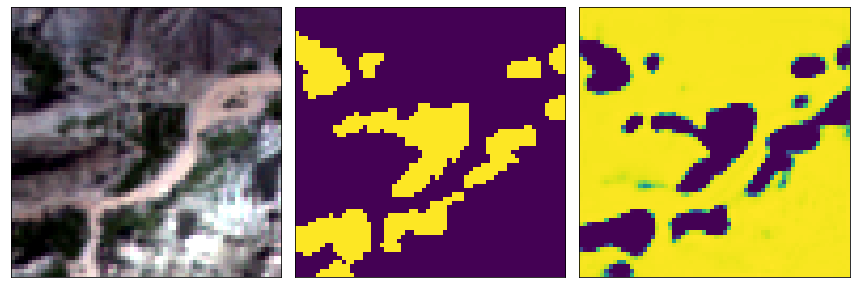

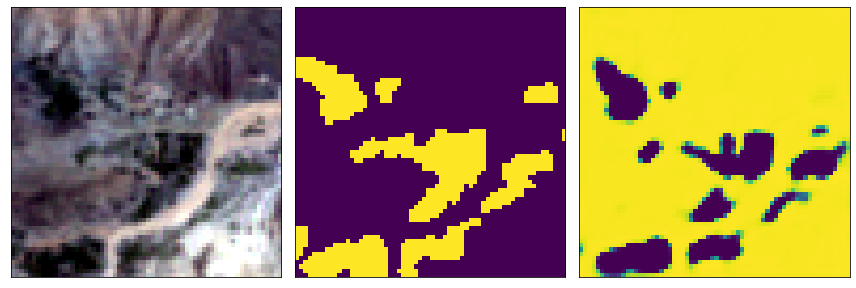

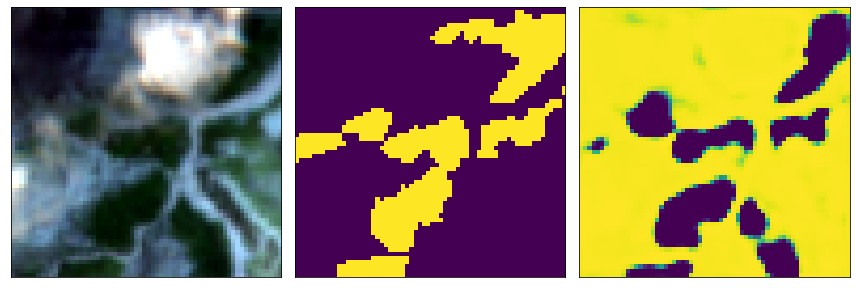

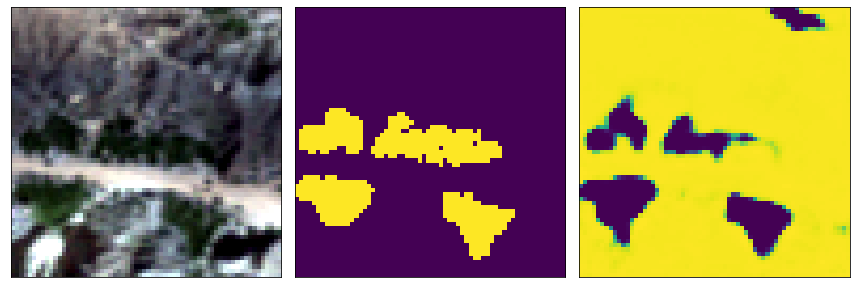

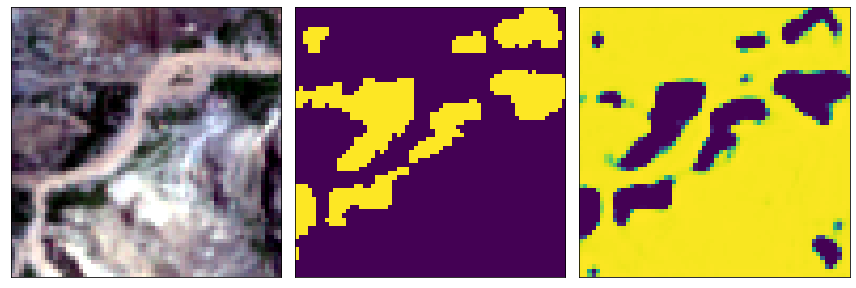

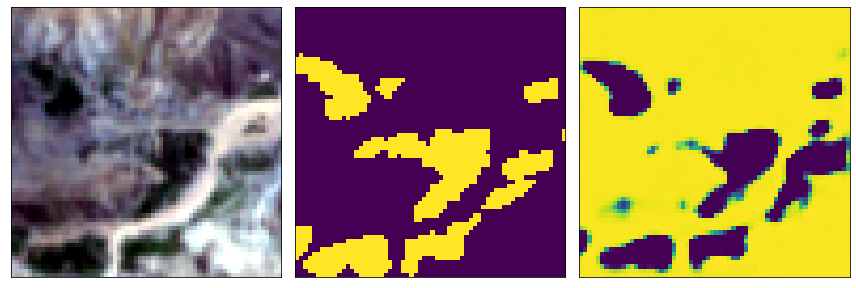

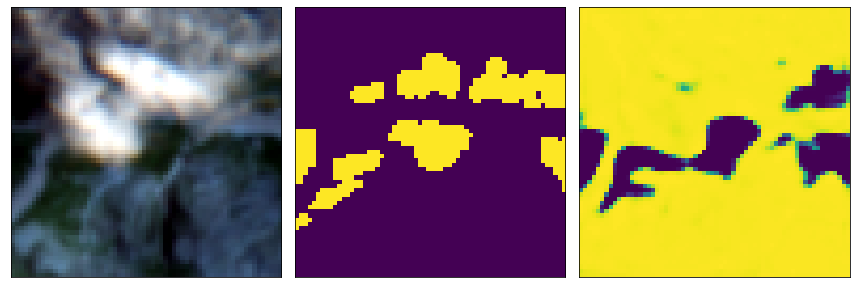

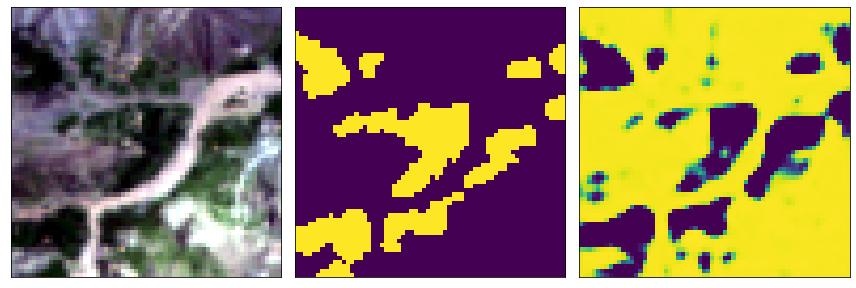

In [16]:
# get groups
test_path = os.path.join( data_path, 'test' )
groups = farm.getLabelGroups( os.path.join( test_path, 'label_stats.csv' ) )

# for each group
max_count = 10
for group in groups:
    
    images = []
    
    df = group.sample(frac=1).reset_index(drop=True)
    for idx, row in df.iterrows():

        # read image and mask
        images.append( farm.loadImages( test_path, row[ 'prefix' ] ) )

        # early exit ?
        if idx == max_count:
            break
    
    # compute prediction
    preds = getPredictions( images )
    
    # load mask
    for idx, row in df.iterrows():

        image = farm.loadImages( test_path, row[ 'prefix' ] )
        label = farm.loadLabels( test_path, row[ 'prefix' ] )

        # plot image vs label mask vs predicted mask
        _, ax = plt.subplots( figsize=(12,8), nrows=1, ncols=3 )
        
        rgb = []
        for channel in range( 3 ):
            rgb.append ( np.asarray( normaliseBand( image[ ::, ::, channel ] ), dtype=np.uint8 ) )
                
        ax[ 0 ].imshow( np.asarray( np.dstack( rgb ) ) )
        ax[ 1 ].imshow( label[ :, :, 0 ] )
        ax[ 2 ].imshow( preds[ idx, :, :, 0 ] )
                
        # configure axes and titles
        for n, title in enumerate( [ 'Input (1,2,3)', 'Actual', 'Predicted' ] ):
            
            ax[ n ].get_xaxis().set_ticks([])
            ax[ n ].get_yaxis().set_ticks([])

            if idx == 0:
                ax[ n ].set_title( title )
        
        # show images
        plt.tight_layout()
        plt.show()

        # early exit ?
        if idx == max_count:
            break

## Further Analysis

In [17]:
from skimage.io import imread

M = N = 64 

# load large s2 ms image
aoi = np.array( imread( os.path.join( data_path, 'aoi.tif' ) ), dtype=np.uint16 )

rows = int( np.ceil( aoi.shape[ 0 ] / M ) * M )
cols = int( np.ceil( aoi.shape[ 1 ] / N ) * N )

aoi_pad = np.zeros( ( rows, cols, 9 ) )
aoi_pad[ :aoi.shape[ 0 ], :aoi.shape[ 1 ], :: ] = aoi

In [18]:
# split into 64 x 64 blocks - with optional zero padding
M = N = 64
tiles = [ aoi_pad[y:y+N,x:x+M,::].astype( np.float64 ) for y in range(0, aoi_pad.shape[0], M ) for x in range(0, aoi_pad.shape[1], N ) ]

# run predictions
preds = getPredictions( tiles )

In [19]:
# reassemble prediction tiles into single image
pred_pad = np.zeros( ( rows, cols, 2 ) )
idx = 0
for y in range(0, aoi_pad.shape[0], M ):
    for x in range(0, aoi_pad.shape[1], N ): 
        pred_pad[ y:y+N, x:x+M,::] = preds[ idx ]
        idx += 1

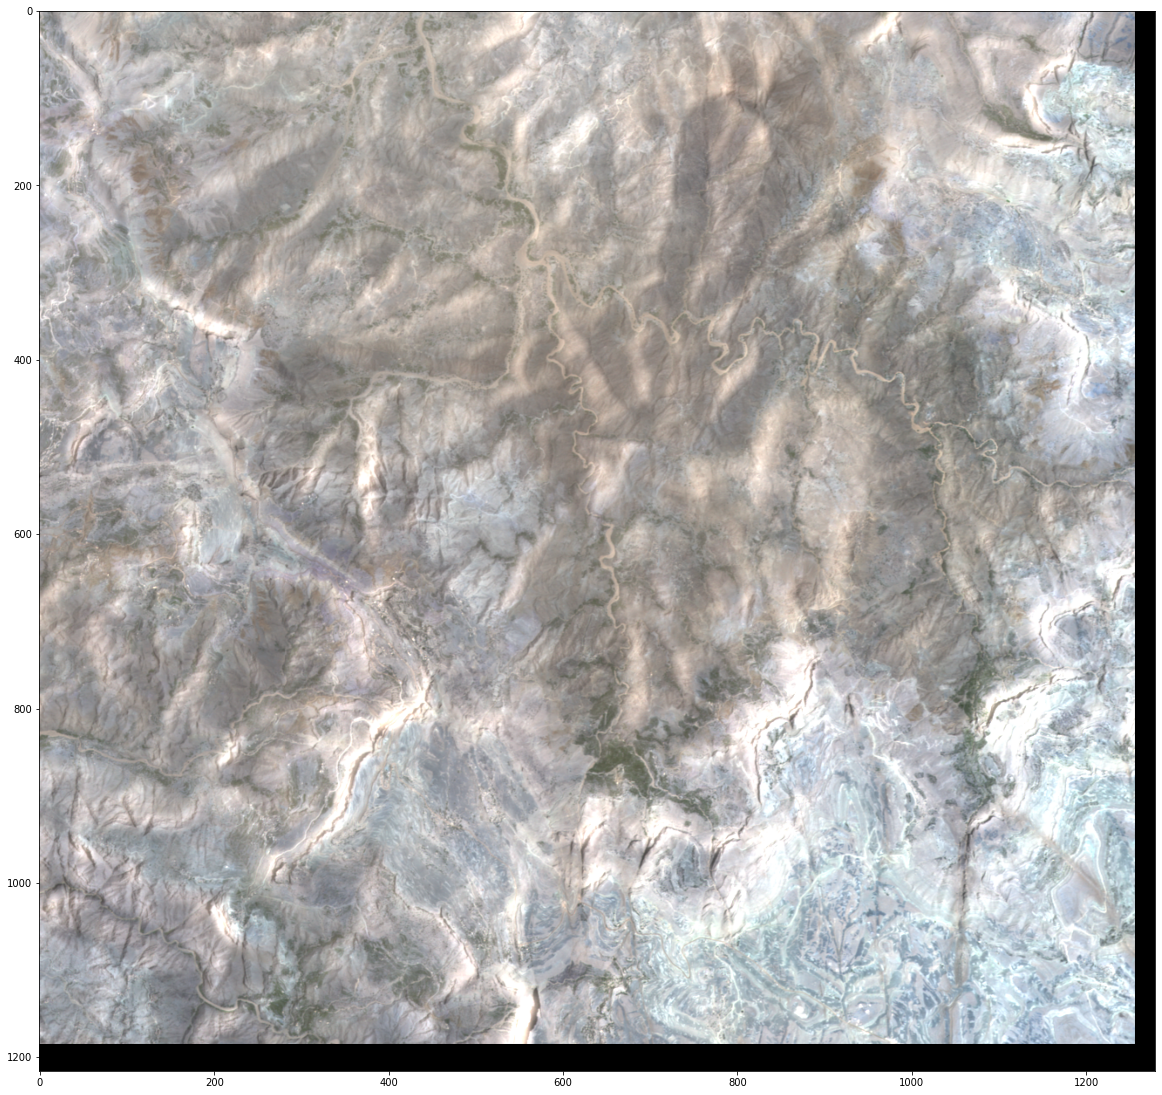

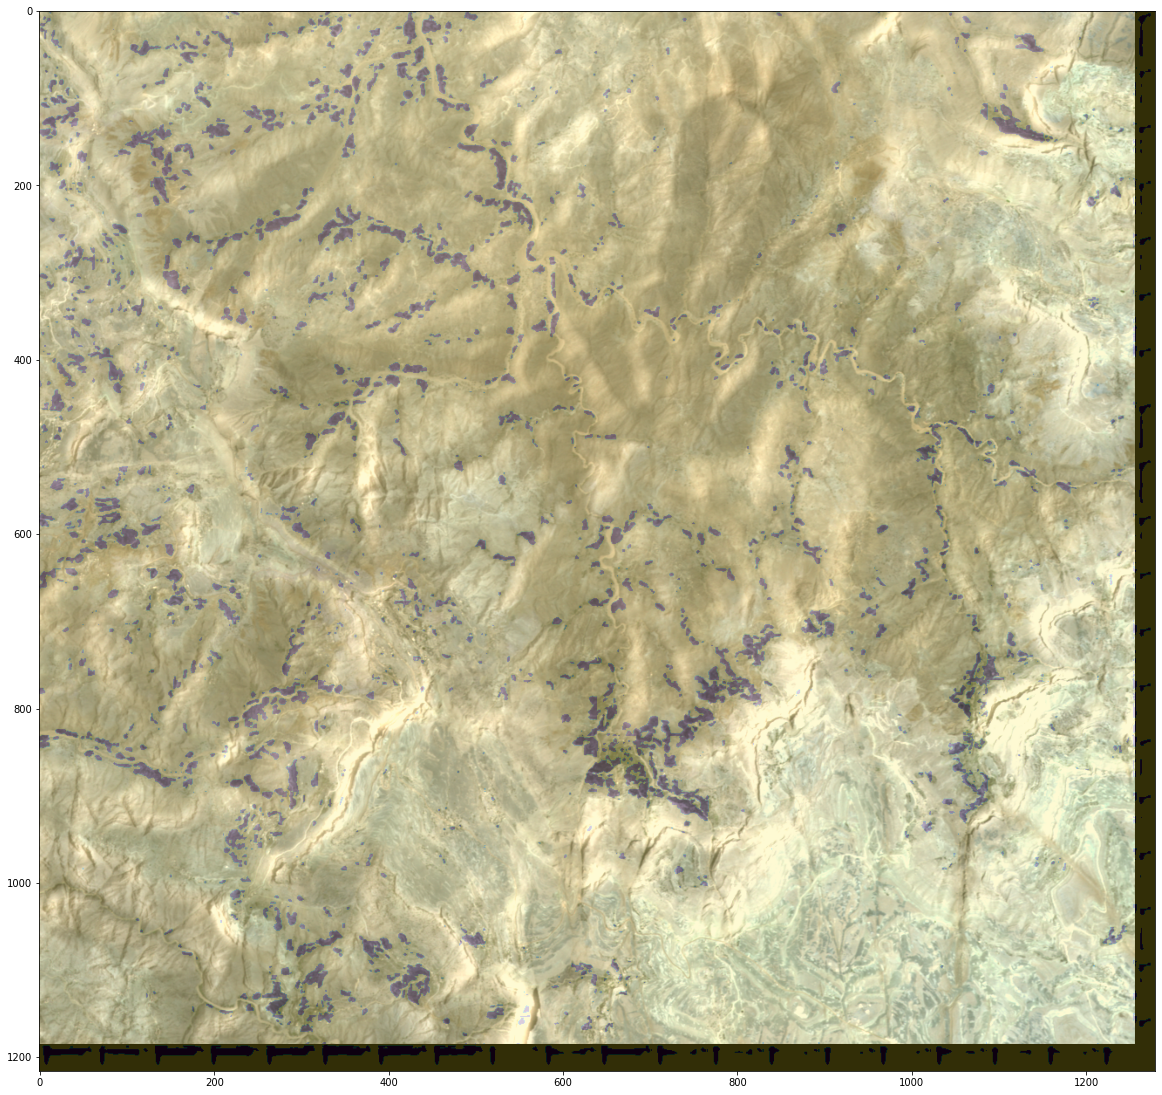

In [20]:
# create rgb image
rgb = []
for channel in range( 3 ):
    rgb.append ( np.asarray( normaliseBand( aoi_pad[ ::, ::, channel ] ), dtype=np.uint8 ) ) 
    
rgb = np.asarray( np.dstack( rgb ) )
    
# plot image 
_, ax = plt.subplots( figsize=(20,20) )
ax.imshow( rgb ) 

mask = pred_pad[ ::, ::, 0 ] >= 0.90
mask = mask.astype(np.uint8) * 255

# plot image 
_, ax = plt.subplots( figsize=(20,20) )
ax.imshow( rgb )
ax.imshow( mask, alpha=0.2 )